In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models import swin_t
import torchvision.transforms as transforms

## Data Loading and Preprocessing


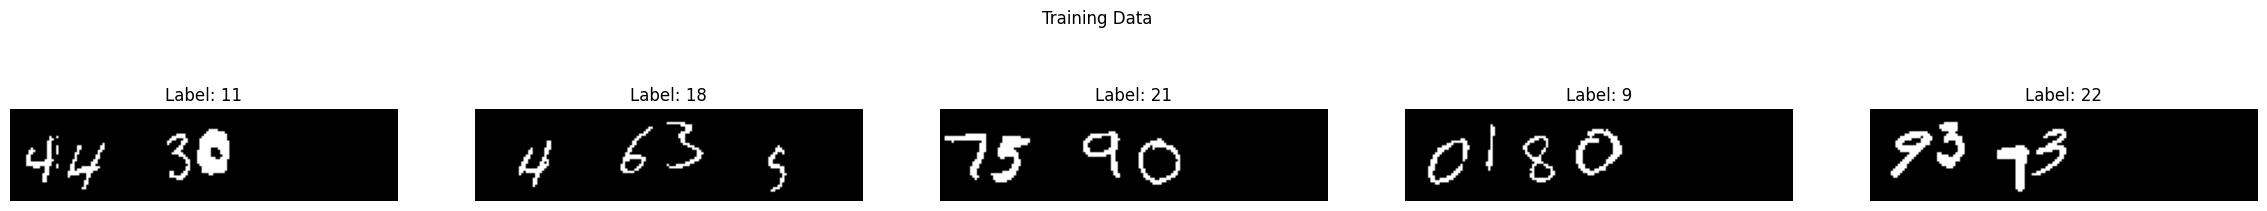

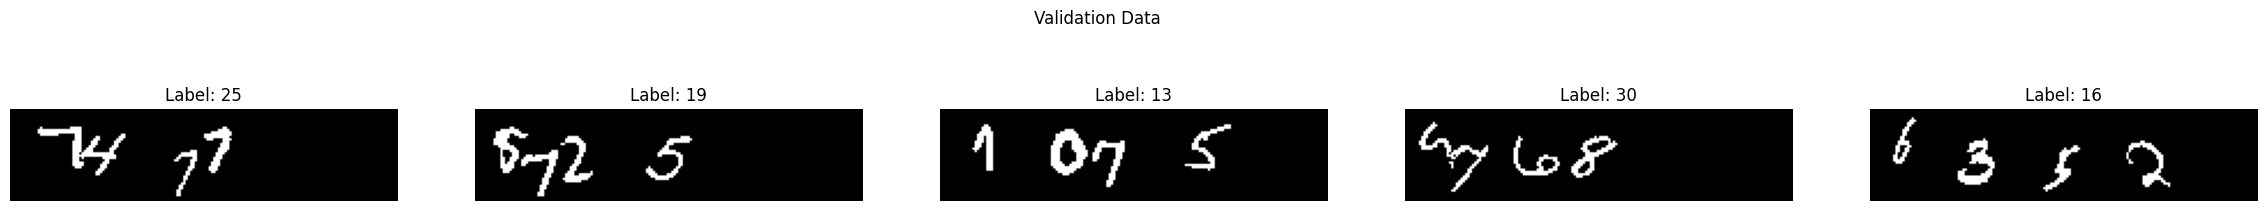

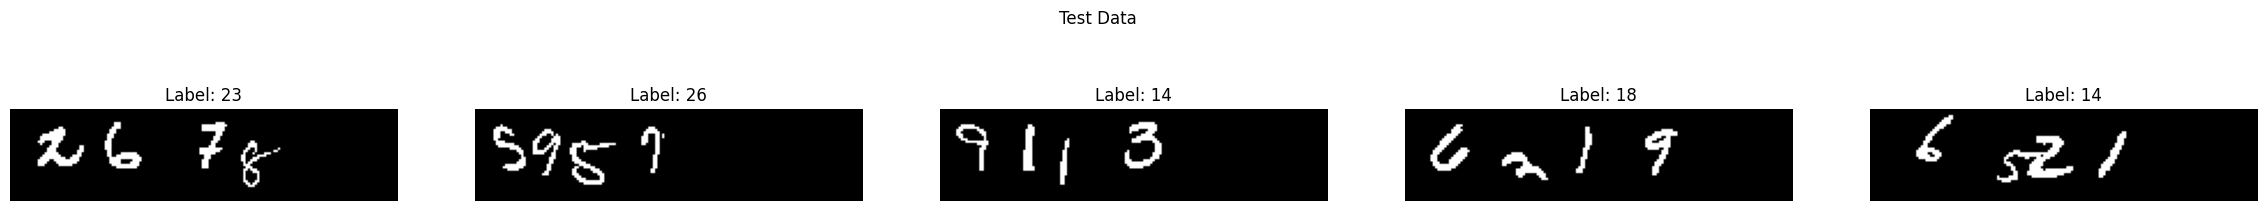

In [28]:

# Load data
img_data_1 = np.load('../data1.npy')
img_data_0 = np.load('../data0.npy')
img_data_2 = np.load('../data2.npy')

img_label1 = np.load('../lab1.npy')
img_label0 = np.load('../lab0.npy')
img_label2 = np.load('../lab2.npy')

# Concatenate all data
all_data = np.concatenate([img_data_0, img_data_1, img_data_2])

# Concatenate all labels
all_labels = np.concatenate([img_label0, img_label1, img_label2])


# Split into train (80%) and temp (20%) datasets
train_data, temp_data, train_labels, temp_labels = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42)

# Split temp into validation (10% of total) and test (10% of total) datasets
val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42)

# Apply binary thresholding to all the data
_, train_data = cv2.threshold(train_data, 127, 255, cv2.THRESH_BINARY)
_, val_data = cv2.threshold(val_data, 127, 255, cv2.THRESH_BINARY)
_, test_data = cv2.threshold(test_data, 127, 255, cv2.THRESH_BINARY)

# Convert to PyTorch tensors and add channel dimension
train_data_tensor = torch.tensor(train_data, dtype=torch.float32).unsqueeze(1)  # Shape: [num_samples, 1, 40, 168]
val_data_tensor = torch.tensor(val_data, dtype=torch.float32).unsqueeze(1)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_data_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize some images from each dataloader
def visualize_dataloader(dataloader, title):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(29, 3))
    axes = np.atleast_1d(axes)  # Ensure axes is iterable

    for idx, ax in enumerate(axes):
        img = images[idx].cpu().numpy()  # Move tensor to CPU and convert to numpy
        img = img.squeeze()  # Remove channel dimension if it's 1
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize images from train, validation, and test dataloaders
visualize_dataloader(train_dataloader, "Training Data")
visualize_dataloader(val_dataloader, "Validation Data")
visualize_dataloader(test_dataloader, "Test Data")

# Preliminary Approach CNN Baseline
---

## Part 1 : Basic CNN

In [4]:
class CNNClassifier(nn.Module):

    def __init__(self):
        super(CNNClassifier, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 5 * 21, out_features=512)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=512, out_features=37)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 5 * 21)
        
        x = self.relu_fc1(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Instantiate the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
patience = 2  # Number of epochs to wait for improvement
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

Using device: cuda


In [6]:
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Calculate average training loss for the epoch
    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
    
    # Calculate average validation loss for the epoch
    correct_val = 0
    total_val = 0
    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # for images, labels in val_dataloader:
    #     images = images.to(device)
    #     labels = labels.to(device)
        
    #     outputs = model(images)
    #     _, predicted = torch.max(outputs.data, 1)
        
    #     total_val += labels.size(0)
    #     correct_val += (predicted == labels).sum().item()
    
    # val_accuracy = 100 * correct_val / total_val
    # print(f'Validation Accuracy: {val_accuracy:.2f}%')

    
    # Print epoch summary
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0

        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')

    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

KeyboardInterrupt: 

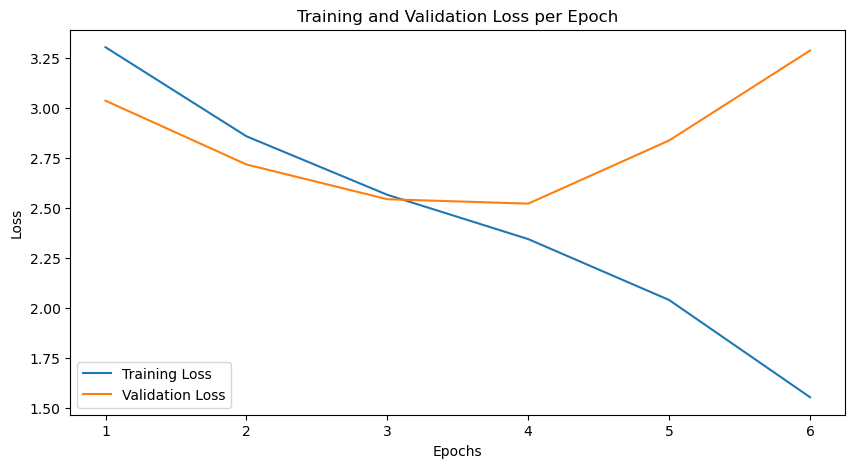

In [69]:
# Plotting losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [70]:
# Evaluation on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 11.13%


## Part 2: Basic Pretrained Resnet

In [3]:
# Load ResNet34
model = models.resnet34(pretrained=False)

# Modify the first convolutional layer for single-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final fully connected layer for 37 classes
model.fc = nn.Linear(model.fc.in_features, 37)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/chinmay/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chinmay/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
num_epochs = 1
patience = 2
best_val_loss = float('inf')
early_stop_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Save the best model
    torch.save(model.state_dict(), 'best_resnet.pth')

Epoch [1/1], Train Loss: 1.0304, Val Loss: 0.9734


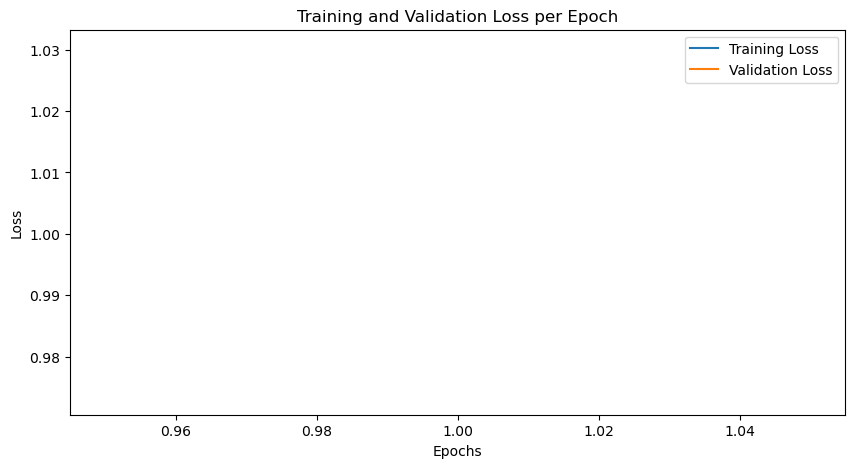

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 64.00%


# SWIN Transformer


Images shape: torch.Size([4, 3, 224, 224])
Labels shape: torch.Size([4])


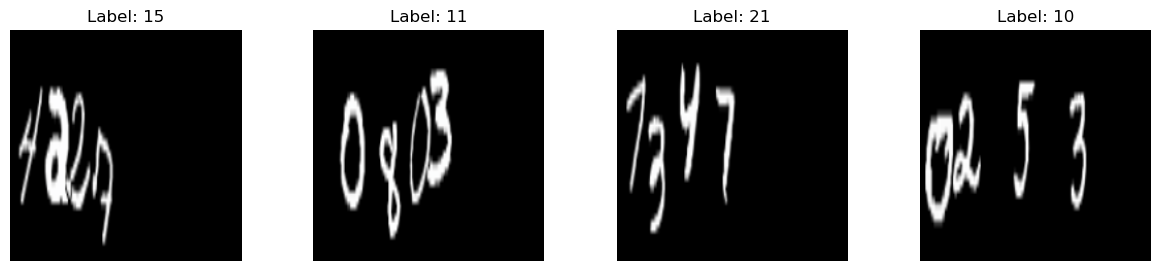

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torchvision.transforms as transforms

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom dataset class
class SumDigitsDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        return image, label

# Custom collate function
def custom_collate(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.stack(labels)
    return images, labels

# Load and prepare the data
train_dataset = SumDigitsDataset(train_data, train_labels, transform=transform_train)
val_dataset = SumDigitsDataset(val_data, val_labels, transform=transform_train)
test_dataset = SumDigitsDataset(test_data, test_labels, transform=transform_train)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate)

# Get a batch of images and labels
images, labels = next(iter(val_dataloader))

# Print shapes of the images and labels
print(f"Images shape: {images.shape}")  # Expected: torch.Size([4, 3, 224, 224])
print(f"Labels shape: {labels.shape}")  # Expected: torch.Size([4])

# Visualize the images
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
axes = np.atleast_1d(axes)  # Ensure axes is iterable

for idx, ax in enumerate(axes):
    img = images[idx].cpu().numpy()  # Move tensor to CPU and convert to numpy
    img = img.transpose((1, 2, 0))  # CHW to HWC
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Label: {labels[idx].item()}")
    ax.axis('off')

plt.show()

In [14]:
model = swin_t(pretrained=True)

# Modify the final classification layer
num_features = model.head.in_features
model.head = nn.Linear(num_features, 37)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [24]:
num_epochs = 1
patience = 1
best_val_loss = float('inf')
early_stop_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch [1/1], Train Loss: 3.1864, Val Loss: 3.1720


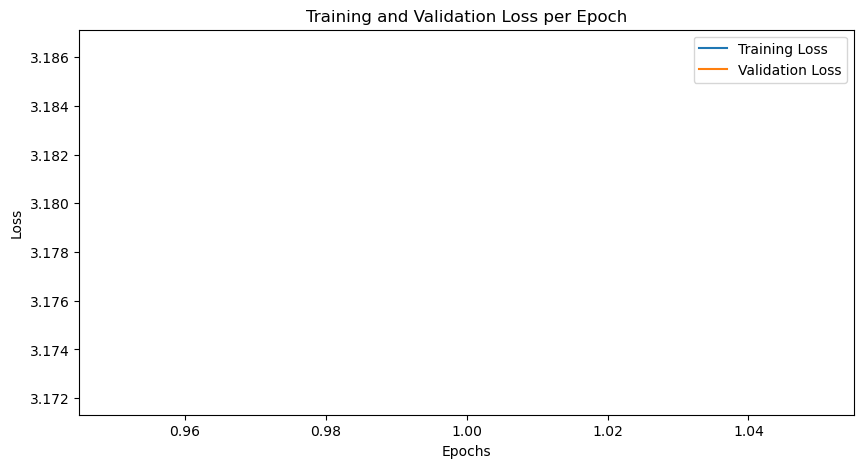

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 6.30%


In [1]:
import cv2
import numpy as np
from pytesseract import pytesseract

In [2]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return thresh

In [15]:
def calculate_digit_sum(image_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Preprocess the image
    processed = preprocess_image(image)
    
    # Find contours
    contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    sum_digits = 0
    
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter out small contours
        if w < 10 or h < 10:
            continue
        
        # Extract ROI
        roi = image[y:y+h, x:x+w]
        
        # Convert ROI to grayscale and apply threshold
        roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        _, roi_thresh = cv2.threshold(roi_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Recognize digit using Tesseract
        digit = pytesseract.image_to_string(roi_thresh, config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
        
        # Convert recognized digit to integer and add to sum
        if digit.isdigit():
            sum_digits += int(digit)
    
    return sum_digits

In [26]:
import cv2
import numpy as np
import torch
import os
from sklearn.neighbors import KNeighborsClassifier
import joblib
# import joblib

# Load the pretrained classifier
import urllib.request

# # Check if the classifier file exists, if not download it
# classifier_path = 'mnist_classifier.pkl'
# if not os.path.exists(classifier_path):
#     url = 'https://example.com/path/to/mnist_classifier.pkl'
#     urllib.request.urlretrieve(url, classifier_path)

# # Load the pretrained classifier
# classifier = joblib.load(classifier_path)

def preprocess_tensor(tensor):
    # Ensure tensor is in the correct format and on CPU
    if tensor.is_cuda:
        tensor = tensor.cpu()
    # Scale to 0-255 and convert to uint8
    tensor = (tensor * 255).byte()
    # Convert to NumPy array
    img = tensor.numpy()
    # Convert to grayscale if necessary
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def separate_digits(thresh):
    # Define erosion and dilation kernels
    kernel = np.ones((2, 2), np.uint8)
    # Apply erosion to break connections
    eroded = cv2.erode(thresh, kernel, iterations=1)
    # Apply dilation to restore digit size
    dilated = cv2.dilate(eroded, kernel, iterations=1)
    return dilated

def find_and_sort_contours(processed_image):
    contours, _ = cv2.findContours(processed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Filter contours based on area
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
    # Sort contours from left to right
    contours = sorted(contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    return contours

def extract_and_classify_digits(original_image, contours, classifier):
    digits = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        digit = original_image[y:y+h, x:x+w]
        # Resize to 28x28 and normalize
        digit = cv2.resize(digit, (28, 28))
        digit = digit.reshape(1, -1).astype(np.float32)/255.0
        # Classify the digit
        prediction = classifier.predict(digit)
        digits.append(prediction[0])
    return digits

def sum_digits(digits):
    return sum(digits)

# Main function to process tensors from dataloaders
def process_dataloader(dataloader, classifier):
    sums = []
    for batch in dataloader:
        # Assuming batch is a single tensor without batches; adjust if necessary
        for tensor in batch:
            # Preprocess the tensor
            img = preprocess_tensor(tensor)
            # Thresholding
            _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            # Separate digits using erosion and dilation
            processed = separate_digits(thresh)
            # Find and sort contours
            contours = find_and_sort_contours(processed)
            # Extract and classify digits
            digits = extract_and_classify_digits(thresh, contours, classifier)
            # Sum the digits
            total_sum = sum_digits(digits)
            sums.append(total_sum)
    return sums

import matplotlib.pyplot as plt

def show_separated_digits(dataloader, num_examples=5):
    examples_shown = 0
    for batch in dataloader:
        for tensor in batch:
            if examples_shown >= num_examples:
                return
            img = preprocess_tensor(tensor)
            _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            processed = separate_digits(thresh)
            contours = find_and_sort_contours(processed)
            # print("HI")
            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                digit = img[y:y+h, x:x+w]
                plt.figure()
                plt.imshow(digit, cmap='gray')
                plt.title('Separated Digit')
                plt.show()
                examples_shown += 1
                if examples_shown >= num_examples:
                    return

# Show examples from the train dataloader
show_separated_digits(train_dataloader)

# Example usage
# train_sums = process_dataloader(train_dataloader, classifier)
# val_sums = process_dataloader(val_dataloader, classifier)
# test_sums = process_dataloader(test_dataloader, classifier)

# print("Train sums:", train_sums)
# print("Validation sums:", val_sums)
# print("Test sums:", test_sums)

HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
HI
H